In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
rs=RobustScaler()
# sc=StandardScaler()
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import math

train = pd.read_csv("train_features.csv")
test = pd.read_csv("test_features.csv")
labels = pd.read_csv("train_labels.csv")
submission = pd.read_csv("sample_submission.csv")

In [ ]:
train.shape,test.shape

((1875000, 8), (469200, 8))

In [ ]:
train.time.nunique(),test.time.nunique()

(600, 600)

In [ ]:
train.id.nunique(),test.id.nunique()

(3125, 782)

In [ ]:
train['time'].nunique()

600

In [ ]:
train.set_index('id').iloc[list(labels[labels['label_desc']=='Dumbbell Row (knee on bench) (left arm)']['id'])].describe()

,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,297.000000,-0.516108,-0.436890,0.174758,28.932082,2.094232,4.481674
std,198.323886,0.571155,0.446704,0.285534,88.308421,19.558168,34.980299
min,55.000000,-0.949042,-1.150019,-0.429259,-49.460436,-30.034035,-63.049773
25%,130.000000,-0.858995,-0.753145,-0.061528,-11.595508,-8.439369,-12.830717
50%,261.000000,-0.766130,-0.576014,0.250860,5.421809,3.924629,4.852779
75%,486.250000,-0.317677,-0.017273,0.431111,24.002368,11.850341,29.517181
max,560.000000,1.043341,0.194261,0.473147,272.482292,35.272634,68.404370


In [ ]:
train.set_index('id').iloc[list(labels[labels['label_desc']=='Dumbbell Row (knee on bench) (right arm)']['id'])].describe() # 오른팔이 왼팔보다 각도 차이가 더 큼

,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,368.583333,-0.492290,-0.016295,0.431158,12.767144,6.481768,-16.139479
std,165.722363,0.690819,0.262562,0.817313,68.475988,25.900239,23.821278
min,29.000000,-1.051479,-0.597854,-0.554143,-137.718510,-30.650846,-53.996618
25%,328.500000,-0.963810,-0.147793,0.015011,-1.181324,-5.215855,-30.319604
50%,451.000000,-0.871769,0.087392,0.265304,0.080834,0.123023,-4.818703
75%,471.000000,-0.139222,0.138934,0.678921,32.382620,7.089148,-0.978524
max,533.000000,0.928874,0.279500,2.678034,124.880259,69.193175,18.486821


변화량(train_change, test_change)

In [ ]:
# amountofchange=pd.DataFrame()
# change_train=train.set_index('id').drop('time',axis=1)
# for j in train['id'].unique():
#     for i in range(599):
#         amountofchange=amountofchange.append(change_train[change_train.index==j].iloc[i+1,:]-change_train[change_train.index==j].iloc[i,:])

# amountofchange=pd.DataFrame()
# change_test=test.set_index('id').drop('time',axis=1)
# for j in test['id'].unique():
#     for i in range(599):
#         amountofchange=amountofchange.append(change_test[change_test.index==j].iloc[i+1,:]-change_test[change_test.index==j].iloc[i,:])


# feature_engineering
- 집계함수 파생변수 Range, IQR (이유는 모르겠지만 아무튼 성능향상)
- 하체운동, 상체운동, 운동X 분류
- 거리 벡터 구하기(변화량?)
- 3차원 오일러각 roll = arctan(y/sqrt(x^2+z^2)), pitch = arctan(x/sqrt(y^2+z^2) , yaw = arctan(sqrt(x^2+y^2)/z
- 0.2초 마다 센서 작동 0.1초 마다로 계산하면 (위 아래의 중앙값을 넣으면됨)

In [ ]:
"""
train_quantile = train[['id', 'time']].groupby('id').quantile([0.25, 0.5, 0.75, 1]).unstack()
train_quantile.columns = ['qt25', 'qt50', 'qt75', 'qt100']
train_quantile = train_quantile.reset_index()

train = pd.merge(train, train_quantile.astype(int), how='left', on='id')

test_quantile = test[['id', 'time']].groupby('id').quantile([0.25, 0.5, 0.75, 1]).unstack()
test_quantile.columns = ['qt25', 'qt50', 'qt75', 'qt100']
test_quantile = test_quantile.reset_index()

test = pd.merge(test, test_quantile.astype(int), how='left', on='id')
"""

"\ntrain_quantile = train[['id', 'time']].groupby('id').quantile([0.25, 0.5, 0.75, 1]).unstack()\ntrain_quantile.columns = ['qt25', 'qt50', 'qt75', 'qt100']\ntrain_quantile = train_quantile.reset_index()\n\ntrain = pd.merge(train, train_quantile.astype(int), how='left', on='id')\n\ntest_quantile = test[['id', 'time']].groupby('id').quantile([0.25, 0.5, 0.75, 1]).unstack()\ntest_quantile.columns = ['qt25', 'qt50', 'qt75', 'qt100']\ntest_quantile = test_quantile.reset_index()\n\ntest = pd.merge(test, test_quantile.astype(int), how='left', on='id')\n"

In [ ]:
# 각축의 벡터
train['acc_vector']=np.sqrt((train['acc_x'] ** 2) +(train['acc_y'] ** 2)+(train['acc_z'] ** 2))
train['gy_vector']=np.sqrt((train['gy_x'] ** 2) +(train['gy_y'] ** 2)+(train['gy_z'] ** 2))
test['acc_vector']=np.sqrt((test['acc_x'] ** 2) +(test['acc_y'] ** 2)+(test['acc_z'] ** 2))
test['gy_vector']=np.sqrt((test['gy_x'] ** 2) +(test['gy_y'] ** 2)+(test['gy_z'] ** 2))

train['acc_YZvector']=np.sqrt((train['acc_y'] ** 2) +(train['acc_z'] ** 2))
train['gy_YZvector']=np.sqrt((train['gy_y'] ** 2) +(train['gy_z'] ** 2))

train['acc_XYvector']=np.sqrt((train['acc_x'] ** 2) +(train['acc_y'] ** 2))
train['gy_XYvector']=np.sqrt((train['gy_x'] ** 2) +(train['gy_y'] ** 2))

train['acc_XZvector']=np.sqrt((train['acc_x'] ** 2) +(train['acc_z'] ** 2))
train['gy_XZvector']=np.sqrt((train['gy_x'] ** 2) +(train['gy_z'] ** 2))

test['acc_YZvector']=np.sqrt((test['acc_y'] ** 2) +(test['acc_z'] ** 2))
test['gy_YZvector']=np.sqrt((test['gy_y'] ** 2) +(test['gy_z'] ** 2))

test['acc_XYvector']=np.sqrt((test['acc_x'] ** 2) +(test['acc_y'] ** 2))
test['gy_XYvector']=np.sqrt((test['gy_x'] ** 2) +(test['gy_y'] ** 2))

test['acc_XZvector']=np.sqrt((test['acc_x'] ** 2) +(test['acc_z'] ** 2))
test['gy_XZvector']=np.sqrt((test['gy_x'] ** 2) +(test['gy_z'] ** 2))

In [ ]:
# 자이로스코프 무게 중심
train['gy_Centerofgravity'] = (train['gy_x']+train['gy_y']+train['gy_z'])/3
test['gy_Centerofgravity'] = (test['gy_x']+test['gy_y']+test['gy_z'])/3

In [ ]:

# 3차원 오일러각
# roll = arctan(y/sqrt(x^2+z^2)) \ pitch = arctan(x/sqrt(y^2+z^2) \ yaw = arctan(sqrt(x^2+y^2)/z
train['roll'] = np.arctan(train['acc_y']/np.sqrt(train['acc_x'] ** 2 + train['acc_z'] ** 2))
test['roll'] = np.arctan(test['acc_y']/np.sqrt(test['acc_x'] ** 2 + test['acc_z'] ** 2))

train['pitch'] = np.arctan(train['acc_x']/np.sqrt(train['acc_y'] ** 2 + train['acc_z'] ** 2))
test['pitch'] = np.arctan(test['acc_x']/np.sqrt(test['acc_y'] ** 2 + test['acc_z'] ** 2))

# 가속도계로는 계산이 불가능 *주석처리*
#train['yaw'] = np.arctan(np.sqrt(train['acc_x'] ** 2 + train['acc_y'] ** 2)/train['acc_z'])

pi = math.pi
# 삼각함수 원리 이용 roll각 
train['math_roll'] = np.arctan(- train['acc_x']/np.sqrt(train['acc_y'] ** 2 + train['acc_z'] ** 2)) * (180/pi)
train['math_pitch'] = np.arctan(train['acc_y']/np.sqrt(train['acc_x'] ** 2 + train['acc_z'] ** 2)) * (180/pi)

test['math_roll'] = np.arctan(- test['acc_x']/np.sqrt(test['acc_y'] ** 2 + test['acc_z'] ** 2)) * (180/pi)
test['math_pitch'] = np.arctan(test['acc_y']/np.sqrt(test['acc_x'] ** 2 + test['acc_z'] ** 2)) * (180/pi)

In [ ]:
# 3차원 오일러각
# roll = arctan(y/sqrt(x^2+z^2)) \ pitch = arctan(x/sqrt(y^2+z^2) \ yaw = arctan(sqrt(x^2+y^2)/z
train['gy_roll'] = np.arctan(train['gy_y']/np.sqrt(train['gy_x'] ** 2 + train['gy_z'] ** 2))
test['gy_roll'] = np.arctan(test['gy_y']/np.sqrt(test['gy_x'] ** 2 + test['gy_z'] ** 2))

train['gy_pitch'] = np.arctan(train['gy_x']/np.sqrt(train['gy_y'] ** 2 + train['gy_z'] ** 2))
test['gy_pitch'] = np.arctan(test['gy_x']/np.sqrt(test['gy_y'] ** 2 + test['gy_z'] ** 2))

# 삼각함수 원리 이용 roll각
pi = math.pi
train['gy_math_roll'] = np.arctan(- train['gy_x']/np.sqrt(train['gy_y'] ** 2 + train['gy_z'] ** 2)) * (180/pi)
train['gy_math_pitch'] = np.arctan(train['gy_y']/np.sqrt(train['gy_x'] ** 2 + train['gy_z'] ** 2)) * (180/pi)

test['gy_math_roll'] = np.arctan(- test['gy_x']/np.sqrt(test['gy_y'] ** 2 + test['gy_z'] ** 2)) * (180/pi)
test['gy_math_pitch'] = np.arctan(test['gy_y']/np.sqrt(test['gy_x'] ** 2 + test['gy_z'] ** 2)) * (180/pi)

In [ ]:
#train['velo_acc_x'] = (train['acc_x'].diff()/train['time']).fillna(0)
#train['velo_acc_y'] = (train['acc_y'].diff()/train['time']).fillna(0)
#train['velo_acc_z'] = (train['acc_z'].diff()/train['time']).fillna(0)

#train['velo_gy_x'] = (train['gy_x'].diff()/train['time']).fillna(0)
#train['velo_gy_y'] = (train['gy_y'].diff()/train['time']).fillna(0)
#train['velo_gy_z'] = (train['gy_z'].diff()/train['time']).fillna(0)

#test['velo_acc_x'] = (test['acc_x'].diff()/train['time']).fillna(0)
#test['velo_acc_y'] = (test['acc_y'].diff()/train['time']).fillna(0)
#test['velo_acc_z'] = (test['acc_z'].diff()/train['time']).fillna(0)

#test['velo_gy_x'] = (test['gy_x'].diff()/test['time']).fillna(0)
#test['velo_gy_y'] = (test['gy_y'].diff()/test['time']).fillna(0)
#test['velo_gy_z'] = (test['gy_z'].diff()/test['time']).fillna(0)

In [ ]:
def range_func(x):
    max_val = np.max(x)
    min_val = np.min(x)
    range_val = max_val - min_val
    return range_val

def iqr_func(x):
    q3, q1 = np.percentile(x, [75, 25])
    iqr = q3 - q1
    return iqr

def iqr_func2(x):
    q3, q1 = np.percentile(x, [20, 80])
    iqr = q3 - q1
    return iqr

def iqr_func3(x):
    q3, q1 = np.percentile(x, [40, 60])
    iqr = q3 - q1
    return iqr

def iqr_func4(x):
    q3, q1 = np.percentile(x, [15, 95])
    iqr = q3 - q1
    return iqr

# iqr 변화

def iqr_func5(x):
    q3, q1 = np.percentile(x, [10, 90])
    iqr = q3 - q1
    return iqr

def iqr_func6(x):
    q3, q1 = np.percentile(x, [5, 85])
    iqr = q3 - q1
    return iqr

def iqr_func7(x):
    q3, q1 = np.percentile(x, [20, 95])
    iqr = q3 - q1
    return iqr

def iqr_func8(x):
    q3, q1 = np.percentile(x, [25, 95])
    iqr = q3 - q1
    return iqr

def iqr_func9(x):
    q3, q1 = np.percentile(x, [5, 95])
    iqr = q3 - q1
    return iqr    

# mad(median_absolute_devation)
def premad(x):
    return np.median(np.absolute(x-np.median(x,axis=0)),axis=0)

# skewness, kurtosis

def preskew(x):
    return skew(x)

def prekurt(x):
    return kurtosis(x,fisher=True)

In [ ]:
"""
# 변동계수
def cv(x):
    result = np.std(x) / np.mean(x)
    return result
    """

'\n# 변동계수\ndef cv(x):\n    result = np.std(x) / np.mean(x)\n    return result\n    '

In [ ]:
train.columns

Index(['id', 'time', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z',
       'acc_vector', 'gy_vector', 'acc_YZvector', 'gy_YZvector',
       'acc_XYvector', 'gy_XYvector', 'acc_XZvector', 'gy_XZvector',
       'gy_Centerofgravity', 'roll', 'pitch', 'math_roll', 'math_pitch',
       'gy_roll', 'gy_pitch', 'gy_math_roll', 'gy_math_pitch'],
      dtype='object')

In [ ]:
features = ['id', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z','acc_vector','gy_vector'
            ,'acc_YZvector','gy_YZvector','acc_XYvector','gy_XYvector','acc_XZvector','gy_XZvector','gy_Centerofgravity']
features2 = ['id', 'roll','pitch','math_roll','math_pitch', 'gy_roll','gy_pitch','gy_math_roll','gy_math_pitch']

train_preprocess = train[features].groupby('id').agg(['max', 'min', 'mean','std','median',range_func,iqr_func2,iqr_func3,iqr_func5,iqr_func9,premad,preskew,prekurt])
temp_train_preprocess = train[features2].groupby('id').agg([range_func,iqr_func2,iqr_func3,iqr_func5,iqr_func9,premad,preskew,prekurt])
test_preprocess = test[features].groupby('id').agg(['max', 'min', 'mean','std','median',range_func,iqr_func2,iqr_func3,iqr_func5,iqr_func9,premad,preskew,prekurt])
temp_test_preprocess = test[features2].groupby('id').agg([range_func,iqr_func2,iqr_func3,iqr_func5,iqr_func9,premad,preskew,prekurt])

train_preprocess=pd.concat([train_preprocess,temp_train_preprocess],axis=1)
test_preprocess=pd.concat([test_preprocess,temp_test_preprocess],axis=1)

train_preprocess.columns=[i[0]+'_'+i[1] for i in train_preprocess.columns]
test_preprocess.columns=[i[0]+'_'+i[1] for i in test_preprocess.columns]

In [ ]:
#train_preprocess['astime'] = (np.trunc(train['time'])*60 + (train['time'] - np.trunc(train['time'])) * 100).astype(int)
#test_preprocess['astime'] = (np.trunc(test['time'])*60 + (test['time'] - np.trunc(test['time'])) * 100).astype(int)

#train_preprocess['time'] = train['time']
#test_preprocess['time'] = test['time']

In [ ]:
# 표준편차의 평균
train_preprocess['acc_std_mean']=(train_preprocess['acc_x_std']+train_preprocess['acc_y_std']+ train_preprocess['acc_z_std'])/3
train_preprocess['gy_std_mean']=(train_preprocess['gy_x_std']+train_preprocess['gy_y_std']+ train_preprocess['gy_z_std'])/3

test_preprocess['acc_std_mean']=(test_preprocess['acc_x_std']+test_preprocess['acc_y_std']+ test_preprocess['acc_z_std'])/3
test_preprocess['gy_std_mean']=(test_preprocess['gy_x_std']+test_preprocess['gy_y_std']+ test_preprocess['gy_z_std'])/3

In [ ]:
#train_preprocess['velo_acc_x'] = (train['acc_x'].diff()/train['time']).fillna(0)
#train_preprocess['velo_acc_y'] = (train['acc_y'].diff()/train['time']).fillna(0)
#train_preprocess['velo_acc_z'] = (train['acc_z'].diff()/train['time']).fillna(0)

#train_preprocess['velo_gy_x'] = (train['gy_x'].diff()/train['time']).fillna(0)
#train_preprocess['velo_gy_y'] = (train['gy_y'].diff()/train['time']).fillna(0)
#train_preprocess['velo_gy_z'] = (train['gy_z'].diff()/train['time']).fillna(0)

#test_preprocess['velo_acc_x'] = (test['acc_x'].diff()/train['time']).fillna(0)
#test_preprocess['velo_acc_y'] = (test['acc_y'].diff()/train['time']).fillna(0)
#test_preprocess['velo_acc_z'] = (test['acc_z'].diff()/train['time']).fillna(0)

#test_preprocess['velo_gy_x'] = (test['gy_x'].diff()/test['time']).fillna(0)
#test_preprocess['velo_gy_y'] = (test['gy_y'].diff()/test['time']).fillna(0)
#test_preprocess['velo_gy_z'] = (test['gy_z'].diff()/test['time']).fillna(0)

In [ ]:
train_preprocess.isna().sum().sum(),test_preprocess.isna().sum().sum()

(0, 0)

상위 1초, 첫번째 데이터, 하위 1초 

In [ ]:
# 첫번째 데이터
train_acc_head1=pd.DataFrame()
for i in train['id'].unique():
    train_acc_head1=train_acc_head1.append(train[['id','acc_x','acc_y','acc_z']][train[['id','acc_x','acc_y','acc_z']]['id']==i].head(1))
train_acc_head1.columns=['id','first_acc_x','first_acc_y','first_acc_z']
train_acc_head1.set_index('id',inplace=True)

train_acc_head1=pd.DataFrame()
for i in train['id'].unique():
    train_acc_head1=train_acc_head1.append(train[['id','gy_x','gy_y','gy_z']][train[['id','gy_x','gy_y','gy_z']]['id']==i].head(1))
train_acc_head1.columns=['id','first_gy_x','first_gy_y','first_gy_z']
train_acc_head1.set_index('id',inplace=True)

test_acc_head1=pd.DataFrame()
for i in test['id'].unique():
    test_acc_head1=test_acc_head1.append(test[['id','acc_x','acc_y','acc_z']][test[['id','acc_x','acc_y','acc_z']]['id']==i].head(1))
test_acc_head1.columns=['id','first_acc_x','first_acc_y','first_acc_z']
test_acc_head1.set_index('id',inplace=True)

test_acc_head1=pd.DataFrame()
for i in test['id'].unique():
    test_acc_head1=test_acc_head1.append(test[['id','gy_x','gy_y','gy_z']][test[['id','gy_x','gy_y','gy_z']]['id']==i].head(1))
test_acc_head1.columns=['id','first_gy_x','first_gy_y','first_gy_z']
test_acc_head1.set_index('id',inplace=True)

In [ ]:
# 첫 3초
train_acc_head=pd.DataFrame()
for i in train['id'].unique():
    train_acc_head=train_acc_head.append(train[['id','acc_x','acc_y','acc_z']][train[['id','acc_x','acc_y','acc_z']]['id']==i].head(150))
train_acc_head.columns=['id','head_acc_x','head_acc_y','head_acc_z']
train_acc_head=train_acc_head.groupby('id').agg(['min','max','mean','std',range_func,premad,preskew,prekurt])

test_acc_head=pd.DataFrame()
for i in test['id'].unique():
    test_acc_head=test_acc_head.append(test[['id','acc_x','acc_y','acc_z']][test[['id','acc_x','acc_y','acc_z']]['id']==i].head(150))
test_acc_head.columns=['id','head_acc_x','head_acc_y','head_acc_z']
test_acc_head=test_acc_head.groupby('id').agg(['min','max','mean','std',range_func,premad,preskew,prekurt])

train_preprocess=pd.concat([train_preprocess,train_acc_head,train_acc_head1],axis=1)
test_preprocess=pd.concat([test_preprocess,test_acc_head,test_acc_head1],axis=1)

# 첫 3초
train_gy_head=pd.DataFrame()
for i in train['id'].unique():
    train_gy_head=train_gy_head.append(train[['id','gy_x','gy_y','gy_z']][train[['id','gy_x','gy_y','gy_z']]['id']==i].head(75))
train_gy_head.columns=['id','head_gy_x','head_gy_y','head_gy_z']
train_gy_head=train_gy_head.groupby('id').agg(['min','max','mean','std',range_func,premad,preskew,prekurt])

test_gy_head=pd.DataFrame()
for i in test['id'].unique():
    test_gy_head=test_gy_head.append(test[['id','gy_x','gy_y','gy_z']][test[['id','gy_x','gy_y','gy_z']]['id']==i].head(75))
test_gy_head.columns=['id','head_gy_x','head_gy_y','head_gy_z']
test_gy_head=test_gy_head.groupby('id').agg(['min','max','mean','std',range_func,premad,preskew,prekurt])

train_preprocess=pd.concat([train_preprocess,train_gy_head],axis=1)
test_preprocess=pd.concat([test_preprocess,test_gy_head],axis=1)

In [ ]:
train_preprocess.describe

<bound method NDFrame.describe of       acc_x_max  acc_x_min  ...  (head_gy_z, preskew)  (head_gy_z, prekurt)
id                          ...                                            
0      1.344268   0.591940  ...             -0.512193             -0.847463
1      1.234020  -2.156208  ...             -0.541195              0.102581
2      1.219836  -1.142847  ...              0.542525             -0.002339
3     -0.622250  -1.417751  ...             -0.348356             -0.223182
4      0.599720  -2.429109  ...             -0.589029              0.262042
...         ...        ...  ...                   ...                   ...
3120   0.390798  -1.624711  ...              0.568557             -0.692066
3121  -0.446650  -1.575455  ...              0.514009             -0.588816
3122   0.744666  -2.578974  ...              0.653345             -0.777851
3123   0.915846  -0.929133  ...             -0.973377              1.194368
3124   0.538809  -1.013813  ...              0.112791 

In [ ]:
#train_preprocess.to_csv('train_preprocess.csv',index=False)
#test_preprocess.to_csv('test_preprocess.csv',index=False)

In [ ]:
train_preprocess = pd.read_csv('train_preprocess_f2.csv')
test_preprocess = pd.read_csv('test_preprocess_f2.csv')

In [ ]:
column_name=list(train_preprocess.iloc[:,:247].columns)
column_name.extend([i[0]+ '-' + i[1] for i in train_preprocess.iloc[:,247:-1].columns])
column_name.extend(list(train_preprocess.iloc[:,-1:].columns))

변화량 추가

In [ ]:
train_change = pd.read_csv('change_train.csv')
test_change = pd.read_csv('change_test.csv')

In [ ]:
train_preprocess.shape,test_preprocess.shape

((3125, 247), (782, 247))

In [ ]:
train_preprocess.isna().sum().sum(),test_preprocess.isna().sum().sum()

(0, 0)

In [ ]:

temp=train_change[['id','acc_x','acc_y','acc_z']]
temp.columns=['id','Cacc_x','Cacc_y','Cacc_z']

#temp['Cacc_centerofgravity']=(temp['Cacc_x']+temp['Cacc_y']+temp['Cacc_z'])/3
temp['Croll'] = np.arctan(temp['Cacc_y']/np.sqrt(temp['Cacc_x'] ** 2 + temp['Cacc_z'] ** 2))
temp['Cpitch'] = np.arctan(temp['Cacc_x']/np.sqrt(temp['Cacc_y'] ** 2 + temp['Cacc_z'] ** 2))
pi = math.pi
temp['Cmath_roll'] = np.arctan(- temp['Cacc_x']/np.sqrt(temp['Cacc_y'] ** 2 + temp['Cacc_z'] ** 2)) * (180/pi)
temp['Cmath_pitch'] = np.arctan(temp['Cacc_y']/np.sqrt(temp['Cacc_x'] ** 2 + temp['Cacc_z'] ** 2)) * (180/pi)
temp=temp.groupby('id').agg(['min','max','mean','std',range_func,premad,preskew,prekurt])
train_preprocess=pd.concat([train_preprocess,temp],axis=1)

temp=train_change[['id','gy_x','gy_y','gy_z']]
temp.columns=['id','Cgy_x','Cgy_y','Cgy_z']

temp['Cgyroll'] = np.arctan(temp['Cgy_y']/np.sqrt(temp['Cgy_x'] ** 2 + temp['Cgy_z'] ** 2))
temp['Cgypitch'] = np.arctan(temp['Cgy_x']/np.sqrt(temp['Cgy_y'] ** 2 + temp['Cgy_z'] ** 2))
pi = math.pi
temp['Cgymath_roll'] = np.arctan(- temp['Cgy_x']/np.sqrt(temp['Cgy_y'] ** 2 + temp['Cgy_z'] ** 2)) * (180/pi)
temp['Cgymath_pitch'] = np.arctan(temp['Cgy_y']/np.sqrt(temp['Cgy_x'] ** 2 + temp['Cgy_z'] ** 2)) * (180/pi)
temp=temp.groupby('id').agg(['min','max','mean','std',range_func,premad,preskew,prekurt])
train_preprocess=pd.concat([train_preprocess,temp],axis=1)

train_preprocess

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,acc_x_max,acc_x_min,acc_x_mean,acc_x_std,acc_x_median,acc_x_range_func,acc_x_iqr_func2,acc_x_iqr_func3,acc_x_iqr_func4,acc_x_premad,acc_x_preskew,acc_x_prekurt,acc_y_max,acc_y_min,acc_y_mean,acc_y_std,acc_y_median,acc_y_range_func,acc_y_iqr_func2,acc_y_iqr_func3,acc_y_iqr_func4,acc_y_premad,acc_y_preskew,acc_y_prekurt,acc_z_max,acc_z_min,acc_z_mean,acc_z_std,acc_z_median,acc_z_range_func,acc_z_iqr_func2,acc_z_iqr_func3,acc_z_iqr_func4,acc_z_premad,acc_z_preskew,acc_z_prekurt,gy_x_max,gy_x_min,gy_x_mean,gy_x_std,...,"(Cgy_z, min)","(Cgy_z, max)","(Cgy_z, mean)","(Cgy_z, std)","(Cgy_z, range_func)","(Cgy_z, premad)","(Cgy_z, preskew)","(Cgy_z, prekurt)","(Cgyroll, min)","(Cgyroll, max)","(Cgyroll, mean)","(Cgyroll, std)","(Cgyroll, range_func)","(Cgyroll, premad)","(Cgyroll, preskew)","(Cgyroll, prekurt)","(Cgypitch, min)","(Cgypitch, max)","(Cgypitch, mean)","(Cgypitch, std)","(Cgypitch, range_func)","(Cgypitch, premad)","(Cgypitch, preskew)","(Cgypitch, prekurt)","(Cgymath_roll, min)","(Cgymath_roll, max)","(Cgymath_roll, mean)","(Cgymath_roll, std)","(Cgymath_roll, range_func)","(Cgymath_roll, premad)","(Cgymath_roll, preskew)","(Cgymath_roll, prekurt)","(Cgymath_pitch, min)","(Cgymath_pitch, max)","(Cgymath_pitch, mean)","(Cgymath_pitch, std)","(Cgymath_pitch, range_func)","(Cgymath_pitch, premad)","(Cgymath_pitch, preskew)","(Cgymath_pitch, prekurt)"
0,1.344268,0.591940,0.931329,0.191479,0.956149,0.752327,-0.369662,-0.172673,-0.544985,0.164385,0.106076,-1.161667,0.176871,-0.624113,-0.218471,0.177131,-0.240638,0.800985,-0.339302,-0.123960,-0.468257,0.138511,0.054884,-0.881409,-0.054876,-0.786336,-0.370422,0.135131,-0.346749,0.731459,-0.230312,-0.060193,-0.353804,0.082231,-0.595532,-0.148805,31.644123,-46.254836,-1.865269,13.284216,...,-13.965281,20.169629,0.106509,4.542548,34.134910,2.833154,0.200250,0.693328,-1.480177,1.484683,-0.033541,0.627901,2.964860,0.447856,-0.003416,-0.584324,-1.537407,1.534200,-0.018014,0.863616,3.071607,0.774576,0.090750,-1.277056,-87.903202,88.086943,1.032124,49.481576,175.990145,44.379921,-0.090750,-1.277056,-84.807919,85.066060,-1.921748,35.976087,169.873979,25.660234,-0.003416,-0.584324
1,1.234020,-2.156208,-0.766580,0.495528,-0.805767,3.390228,-0.892320,-0.259957,-1.126772,0.321762,-0.202959,0.229016,0.700065,-1.295598,-0.317258,0.336415,-0.228905,1.995663,-0.624780,-0.261024,-0.888156,0.232913,-0.145735,-0.589686,0.888661,-1.019531,-0.004223,0.499395,-0.034583,1.908192,-0.911407,-0.190953,-1.412183,0.382460,-0.137812,-0.764662,286.624363,-325.328531,11.071600,79.244561,...,-67.066554,64.125090,-0.045572,14.919455,131.191643,3.947651,0.068497,3.872017,-1.506159,1.495188,0.009797,0.683328,3.001347,0.489228,-0.073283,-0.620949,-1.531530,1.546866,-0.007951,0.822457,3.078396,0.713602,0.044136,-1.145265,-88.628892,87.750209,0.455573,47.123326,176.379100,40.886396,-0.044136,-1.145265,-86.296562,85.667951,0.561320,39.151784,171.964513,28.030691,-0.073283,-0.620949
2,1.219836,-1.142847,0.039836,0.711972,0.140667,2.362683,-1.561197,-0.761086,-1.807555,0.644637,-0.180743,-1.531553,0.650645,-0.690990,-0.082403,0.147127,-0.062598,1.341634,-0.173898,-0.042867,-0.321375,0.061567,-0.409084,3.478554,1.332992,0.073846,0.626012,0.248807,0.634781,1.259146,-0.496052,-0.195792,-0.665546,0.214759,0.091623,-1.033791,73.525082,-164.779067,-8.472951,25.422926,...,-26.885585,36.865551,0.057367,7.380564,63.751136,3.842362,0.351238,2.389410,-1.552650,1.555699,0.057660,0.854269,3.108350,0.732678,-0.047991,-1.184095,-1.537676,1.522336,-0.030351,0.763793,3.060012,0.581990,0.035938,-0.897360,-87.223442,88.102347,1.738997,43.762136,175.325789,33.345552,-0.035938,-0.897360,-88.960305,89.135004,3.303674,48.946037,178.095309,41.979341,-0.047991,-1.184095
3,-0.622250,-1.417751,-0.887702,0.130899,-0.880343,0.795502,-0.227442,-0.070906,-0.332513,0.098201,-0.606239,0.662947,0.283721,-0.540827,-0.087668,0.194008,-0.054577,0.824548,-0.361539,-0.100108,-0.512874,0.138254,-0.388269,-0.739255,0.598814,-0.257124,0.227357,0.205882,0.23153

In [ ]:

temp=test_change[['id','acc_x','acc_y','acc_z']]
temp.columns=['id','Cacc_x','Cacc_y','Cacc_z']

#temp['Cacc_centerofgravity']=(temp['Cacc_x']+temp['Cacc_y']+temp['Cacc_z'])/3
temp['Croll'] = np.arctan(temp['Cacc_y']/np.sqrt(temp['Cacc_x'] ** 2 + temp['Cacc_z'] ** 2))
temp['Cpitch'] = np.arctan(temp['Cacc_x']/np.sqrt(temp['Cacc_y'] ** 2 + temp['Cacc_z'] ** 2))
pi = math.pi
temp['Cmath_roll'] = np.arctan(- temp['Cacc_x']/np.sqrt(temp['Cacc_y'] ** 2 + temp['Cacc_z'] ** 2)) * (180/pi)
temp['Cmath_pitch'] = np.arctan(temp['Cacc_y']/np.sqrt(temp['Cacc_x'] ** 2 + temp['Cacc_z'] ** 2)) * (180/pi)
temp=temp.groupby('id').agg(['min','max','mean','std',range_func,premad,preskew,prekurt])
test_preprocess=pd.concat([test_preprocess,temp],axis=1)

temp=test_change[['id','gy_x','gy_y','gy_z']]
temp.columns=['id','Cgy_x','Cgy_y','Cgy_z']

temp['Cgyroll'] = np.arctan(temp['Cgy_y']/np.sqrt(temp['Cgy_x'] ** 2 + temp['Cgy_z'] ** 2))
temp['Cgypitch'] = np.arctan(temp['Cgy_x']/np.sqrt(temp['Cgy_y'] ** 2 + temp['Cgy_z'] ** 2))
pi = math.pi
temp['Cgymath_roll'] = np.arctan(- temp['Cgy_x']/np.sqrt(temp['Cgy_y'] ** 2 + temp['Cgy_z'] ** 2)) * (180/pi)
temp['Cgymath_pitch'] = np.arctan(temp['Cgy_y']/np.sqrt(temp['Cgy_x'] ** 2 + temp['Cgy_z'] ** 2)) * (180/pi)
temp=temp.groupby('id').agg(['min','max','mean','std',range_func,premad,preskew,prekurt])
test_preprocess=pd.concat([test_preprocess,temp],axis=1)

test_preprocess


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,acc_x_max,acc_x_min,acc_x_mean,acc_x_std,acc_x_median,acc_x_range_func,acc_x_iqr_func2,acc_x_iqr_func3,acc_x_iqr_func4,acc_x_premad,acc_x_preskew,acc_x_prekurt,acc_y_max,acc_y_min,acc_y_mean,acc_y_std,acc_y_median,acc_y_range_func,acc_y_iqr_func2,acc_y_iqr_func3,acc_y_iqr_func4,acc_y_premad,acc_y_preskew,acc_y_prekurt,acc_z_max,acc_z_min,acc_z_mean,acc_z_std,acc_z_median,acc_z_range_func,acc_z_iqr_func2,acc_z_iqr_func3,acc_z_iqr_func4,acc_z_premad,acc_z_preskew,acc_z_prekurt,gy_x_max,gy_x_min,gy_x_mean,gy_x_std,...,"(Cgy_z, min)","(Cgy_z, max)","(Cgy_z, mean)","(Cgy_z, std)","(Cgy_z, range_func)","(Cgy_z, premad)","(Cgy_z, preskew)","(Cgy_z, prekurt)","(Cgyroll, min)","(Cgyroll, max)","(Cgyroll, mean)","(Cgyroll, std)","(Cgyroll, range_func)","(Cgyroll, premad)","(Cgyroll, preskew)","(Cgyroll, prekurt)","(Cgypitch, min)","(Cgypitch, max)","(Cgypitch, mean)","(Cgypitch, std)","(Cgypitch, range_func)","(Cgypitch, premad)","(Cgypitch, preskew)","(Cgypitch, prekurt)","(Cgymath_roll, min)","(Cgymath_roll, max)","(Cgymath_roll, mean)","(Cgymath_roll, std)","(Cgymath_roll, range_func)","(Cgymath_roll, premad)","(Cgymath_roll, preskew)","(Cgymath_roll, prekurt)","(Cgymath_pitch, min)","(Cgymath_pitch, max)","(Cgymath_pitch, mean)","(Cgymath_pitch, std)","(Cgymath_pitch, range_func)","(Cgymath_pitch, premad)","(Cgymath_pitch, preskew)","(Cgymath_pitch, prekurt)"
0,-0.275446,-1.564000,-1.018731,0.236232,-1.064222,1.288554,-0.408878,-0.085778,-0.650576,0.144306,0.479478,-0.108082,0.228040,-0.470937,-0.019574,0.091641,-0.005735,0.698976,-0.134806,-0.030381,-0.215997,0.052060,-0.736383,1.782043,0.286182,-0.573836,-0.232259,0.174672,-0.268442,0.860018,-0.330837,-0.104791,-0.483860,0.129298,0.439717,-0.671472,56.953059,-50.429364,-3.185128,12.897967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.627571,-1.929033,-0.522843,0.539688,-0.677411,2.556604,-0.979996,-0.177712,-1.558561,0.273615,0.781933,-0.439259,1.708743,-0.200678,0.612161,0.333015,0.606215,1.909422,-0.618040,-0.235915,-0.893509,0.269067,0.141358,-0.558259,0.671876,-1.212052,-0.071092,0.383800,-0.026089,1.883927,-0.700898,-0.279616,-1.145145,0.278699,0.201677,-0.790734,132.830402,-273.572486,-17.741526,51.625096,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.972063,-0.792916,0.506947,0.219934,0.497370,3.764978,-0.153769,-0.036839,-0.316653,0.055507,2.594860,42.977585,1.941820,0.219008,0.903819,0.191485,0.931239,1.722812,-0.328960,-0.128553,-0.504488,0.142896,0.048228,0.854547,0.644154,-0.484614,-0.141098,0.152077,-0.156647,1.128767,-0.264008,-0.104349,-0.416204,0.109579,0.344382,0.438891,160.426058,-99.799971,-2.179745,22.770845,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.337281,-1.045889,-0.577603,0.431713,-0.880541,1.383170,-0.836014,-0.294711,-1.096959,0.095699,0.631184,-1.294690,-0.258476,-1.294482,-0.610557,0.233601,-0.507927,1.036006,-0.432697,-0.110460,-0.683618,0.112980,-0.707660,-0.581285,0.702574,-0.469924,0.031486,0.326569,-0.092860,1.172497,-0.575607,-0.022587,-0.830391,0.046761,0.766024,-0.573780,119.527887,-229.072919,0.808579,42.818157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.015642,-2.153047,-0.738640,0.305797,-0.703842,2.168689,-0.427487,-0.075851,-0.843176,0.156308,-0.333323,0.881997,1.562602,-0.860883,0.182535,0.314294,0.122280,2.423485,-0.550816,-0.129384,-0.797277,0.191663,0.243577,0.368275,1.037876,-0.631258,0.401302,0.261848,0.432678,1.669134,-0.464170,-0.193668,-0.653561,0.180134,-0.511312,0.311924,366.167357,-345.447240,-1.431538,92.301963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
train_preprocess.isna().sum().sum(),test_preprocess.isna().sum().sum()

(0, 286994)

In [ ]:
train_preprocess.shape,test_preprocess.shape

((3125, 367), (1564, 367))

군집화(Kmeans, Hierachical Clustering)
- Hierachical

In [ ]:
#plt.figure(figsize=(20, 5))
#plt.title("Customer Dendograms")
#dend = shc.dendrogram(shc.linkage(train_preprocess, method='average'))

In [ ]:
#plt.figure(figsize=(20, 5))
#plt.title("Customer Dendograms")
#dend = shc.dendrogram(shc.linkage(train_preprocess, method='complete'))

In [ ]:
#plt.figure(figsize=(20, 7))
#plt.title("Customer Dendograms")
#dend = shc.dendrogram(shc.linkage(train_preprocess, method='ward'))

In [ ]:
# cluster=AgglomerativeClustering(n_clusters=5, affinity="euclidean",linkage='complete')
# predict=cluster.fit(train_preprocess)
# train_preprocess['cluster']=predict

# predict=cluster.predict(test_preprocess)
# test_preprocess['cluster']=predict

In [ ]:
X_train = train_preprocess

In [ ]:
X_test = test_preprocess

In [ ]:
X_train.shape,X_test.shape

((3125, 432), (782, 432))

In [ ]:
y_train = labels['label']

In [ ]:
list(labels['label_desc'].unique())

['Shoulder Press (dumbbell)',
 'Non-Exercise',
 'Biceps Curl (band)',
 'Side Plank Right side',
 'Plank',
 'Chest Press (rack)',
 'Wall Squat',
 'Russian Twist',
 'Running (treadmill)',
 'Pushup (knee or foot variation)',
 'Wall Ball',
 'Dynamic Stretch (at your own pace)',
 'Sit-up (hands positioned behind head)',
 'Tap Right Device',
 'Static Stretch (at your own pace)',
 'Device on Table',
 'Triceps extension (lying down)',
 'Elliptical machine',
 'Burpee',
 'Walking lunge',
 'Lateral Raise',
 'Jump Rope',
 'Triceps Kickback (knee on bench) (label spans both arms)',
 'Medicine Ball Slam',
 'Lunge (alternating both legs, weight optional)',
 'Fast Alternating Punches',
 'Static stretch',
 'Squat Rack Shoulder Press',
 'Overhead Triceps Extension',
 'Seated Back Fly',
 'Bicep Curl',
 'Side Plank Left side',
 'Dumbbell Squat (hands at side)',
 'Dumbbell Deadlift Row',
 'Two-arm Dumbbell Curl (both arms, not alternating)',
 'Walk',
 'Arm Band Adjustment',
 'Band Pull-Down Row',
 'Squat J

- PCA

In [ ]:
"""
from sklearn import decomposition

model = decomposition.PCA()
model.fit(train_preprocess)
"""

'\nfrom sklearn import decomposition\n\nmodel = decomposition.PCA()\nmodel.fit(train_preprocess)\n'

- Kmeans

In [ ]:
model = KMeans(n_clusters=6,random_state=20)
model.fit(X_train)
train_predict = model.predict(X_train)
X_train['cluster']=train_predict

test_predict = model.predict(X_test)
X_test['cluster']=test_predict

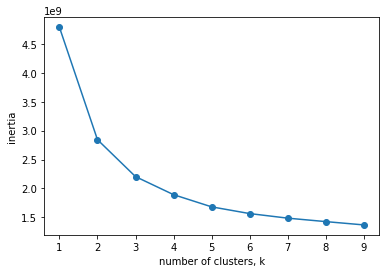

In [ ]:
ks = range(1,10)

inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X_train)
    inertias.append(model.inertia_)

    

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

스케일링

In [ ]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#scaler.fit(X_train)
#train_scaled = scaler.transform(X_train)

#scaler.fit(X_test)
#test_scaled = scaler.transform(X_test)

In [ ]:
# train_scaled,test_scaled

GridSearchCV

In [ ]:
#from sklearn.model_selection import GridSearchCV
#param_grid = {'learning_rate': [0.04, 0.1],'depth': [7, 11],'l2_leaf_reg': [1, 3,9]}
#model = CatBoostClassifier(n_estimators=5000, learning_rate=0.05,random_seed=0, task_type="GPU", verbose=50)
#grid_search = GridSearchCV(model, param_grid, cv=5)        
#grid_search.fit(X_train, y_train)
#grid_search.score(X_test, y_test)
#y_pred = grid_search.predict_proba(X_test)
#submission.iloc[:,1:] = y_pred
#submission.to_csv("gridmodel.csv",index=False)

In [ ]:
#y_pred = grid_search.predict_proba(X_test)
#submission.iloc[:,1:] = y_pred
#submission.to_csv("gridmodel.csv",index=False)

데이터 증강 SMOTE

In [ ]:
"""
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
sm = SMOTE(n_jobs=-1,random_state=42)
smteen=SMOTEENN(random_state=42)
smtet=SMOTETomek(random_state=42)

sm_X_train,sm_y_train=sm.fit_sample(X_train,y_train)
"""

'\nfrom imblearn.over_sampling import SMOTE\nfrom imblearn.combine import SMOTEENN, SMOTETomek\nsm = SMOTE(n_jobs=-1,random_state=42)\nsmteen=SMOTEENN(random_state=42)\nsmtet=SMOTETomek(random_state=42)\n\nsm_X_train,sm_y_train=sm.fit_sample(X_train,y_train)\n'

In [ ]:
#sm_X_train.to_csv('sm_X_train.csv', index=False)
#sm_y_train.to_csv('sm_y_train.csv', index=False)

In [ ]:
X_train.shape

(3125, 435)

In [ ]:
y_train.shape

(3125,)

# 모델링
- Catboost (n_estimators=5000,learning_rate=0.05,random_state=42,task_type='GPU',early_stopping_rounds=50)
- kfold (n_split = 10)

- Add math_roll, math_pitch (bestTest = 0.740924884)
- Add math_roll,math_pitch,skewness,kurtosis (bestTest = 0.7205488981)
- Add ~ , mad (bestTest = 0.7165811446) (kfold bestTest = 0.8337657635)
- best8 : 0.6277604749(add 2)


In [ ]:
from sklearn.model_selection import train_test_split

X_train2,X_valid2,y_train2,y_valid2 = train_test_split(train_preprocess,y_train,random_state=0,test_size=0.25)

In [ ]:
# random_state=20,early_stopping_rounds=700,iterations=100000,task_type='GPU'
# n_estimators=10000,learning_rate=0.05,random_state=42, task_type="GPU",early_stopping_rounds=100
# grow_policy = 'Depthwise', depth = 10
model = CatBoostClassifier(random_state=20,early_stopping_rounds=700,learning_rate=0.05,iterations=100000,task_type='GPU')
model.fit(X_train2,y_train2,eval_set=[(X_valid2,y_valid2)])

0:	learn: 3.2621293	test: 3.3071982	best: 3.3071982 (0)	total: 64.4ms	remaining: 1h 47m 23s
1:	learn: 3.0659021	test: 3.1219205	best: 3.1219205 (1)	total: 118ms	remaining: 1h 38m 35s
2:	learn: 2.9199365	test: 2.9920742	best: 2.9920742 (2)	total: 187ms	remaining: 1h 43m 58s
3:	learn: 2.7958157	test: 2.8777979	best: 2.8777979 (3)	total: 253ms	remaining: 1h 45m 32s
4:	learn: 2.6965273	test: 2.7874681	best: 2.7874681 (4)	total: 322ms	remaining: 1h 47m 19s
5:	learn: 2.5935299	test: 2.6920013	best: 2.6920013 (5)	total: 373ms	remaining: 1h 43m 29s
6:	learn: 2.5094184	test: 2.6101850	best: 2.6101850 (6)	total: 426ms	remaining: 1h 41m 24s
7:	learn: 2.4387246	test: 2.5465978	best: 2.5465978 (7)	total: 482ms	remaining: 1h 40m 22s
8:	learn: 2.3713751	test: 2.4867178	best: 2.4867178 (8)	total: 541ms	remaining: 1h 40m 14s
9:	learn: 2.3045079	test: 2.4234956	best: 2.4234956 (9)	total: 589ms	remaining: 1h 38m 11s
10:	learn: 2.2439091	test: 2.3685020	best: 2.3685020 (10)	total: 646ms	remaining: 1h 37m 

In [ ]:
import joblib
joblib.dump(model,'/content/drive/MyDrive/Colab Notebooks/best7_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/best7_model.pkl']

In [ ]:
# 모델 로드
model = joblib.load('/content/drive/MyDrive/Colab Notebooks/best7_model.pkl')

In [ ]:
model

In [ ]:
pip install eli5

In [ ]:
column_name=[i[0]+ '-' + i[1] for i in X_valid2.columns[:-1]]
column_name.append('cluster')

In [ ]:
column_name

['a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'a-c',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',
 'g-y',


In [ ]:
#import eli5
#from eli5.sklearn import PermutationImportance 
#perm = PermutationImportance(model, random_state = 42).fit(X_valid2, y_valid2) 
model_weight = eli5.show_weights(perm,top=500, feature_names = column_name)

In [ ]:
#pd.DataFrame(eli5.show_weights(perm, top = 500, feature_names = valid_x.columns.tolist())).to_csv('weight.csv',index=False)

In [ ]:
model_weight

Weight,Feature
0.0125 ± 0.0034,a-c
0.0051 ± 0.0016,a-c
0.0033 ± 0.0035,a-c
0.0031 ± 0.0013,p-i
0.0026 ± 0.0000,head_acc_z-min
0.0026 ± 0.0000,head_acc_y-prekurt
0.0023 ± 0.0041,head_gy_x-mean
0.0023 ± 0.0041,g-y
0.0023 ± 0.0010,a-c
0.0023 ± 0.0019,head_acc_y-max


In [ ]:
#import seaborn as sns

#ftr_importances_values = model.feature_importances_
#ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
#ftr_top20 = ftr_importances.sort_values(ascending=False)
#plt.figure(figsize=(30,20))
#plt.title('Feature importances Top 20')
#sns.barplot(x=ftr_top20, y= ftr_top20.index)
#plt.show()

In [ ]:
X_train.columns

Index([                    'acc_x_max',                     'acc_x_min',
                          'acc_x_mean',                     'acc_x_std',
                        'acc_x_median',              'acc_x_range_func',
                     'acc_x_iqr_func2',               'acc_x_iqr_func3',
                     'acc_x_iqr_func5',               'acc_x_iqr_func9',
       ...
           ('Cgymath_roll', 'prekurt'),        ('Cgymath_pitch', 'min'),
              ('Cgymath_pitch', 'max'),       ('Cgymath_pitch', 'mean'),
              ('Cgymath_pitch', 'std'), ('Cgymath_pitch', 'range_func'),
           ('Cgymath_pitch', 'premad'),    ('Cgymath_pitch', 'preskew'),
          ('Cgymath_pitch', 'prekurt'),                       'cluster'],
      dtype='object', length=435)

In [ ]:
#drop_columns=["('head_gy_x', 'premad')"]
#model.fit(X_train2.drop(drop_columns,axis=1), y_train2,eval_set=[(X_valid2.drop(drop_columns,axis=1),y_valid2)])

In [ ]:
X_train.shape,X_test.shape

((3125, 435), (782, 435))

In [ ]:
skf=KFold(n_splits=10, shuffle=True, random_state=0)

predict=0
loop=0
for train_index, valid_index in skf.split(X_train,labels['label']):
    loop+=1
    print('-'*45+'{}번째 {}번째'.format(loop,loop),'-'*45)
    train_x, valid_x = X_train.iloc[train_index], X_train.iloc[valid_index]
    train_y, valid_y = labels['label'][train_index], labels['label'][valid_index]
    model.fit(train_x, train_y,eval_set=[(valid_x,valid_y)])
    predict+=model.predict_proba(X_test)/10

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
3746:	learn: 0.0133587	test: 0.5462199	best: 0.5461652 (3708)	total: 3m 51s	remaining: 1h 39m 6s
3747:	learn: 0.0133547	test: 0.5462307	best: 0.5461652 (3708)	total: 3m 51s	remaining: 1h 39m 6s
3748:	learn: 0.0133489	test: 0.5462050	best: 0.5461652 (3708)	total: 3m 51s	remaining: 1h 39m 6s
3749:	learn: 0.0133430	test: 0.5462584	best: 0.5461652 (3708)	total: 3m 51s	remaining: 1h 39m 6s
3750:	learn: 0.0133386	test: 0.5462941	best: 0.5461652 (3708)	total: 3m 51s	remaining: 1h 39m 6s
3751:	learn: 0.0133352	test: 0.5462850	best: 0.5461652 (3708)	total: 3m 51s	remaining: 1h 39m 6s
3752:	learn: 0.0133304	test: 0.5463185	best: 0.5461652 (3708)	total: 3m 51s	remaining: 1h 39m 6s
3753:	learn: 0.0133243	test: 0.5463326	best: 0.5461652 (3708)	total: 3m 51s	remaining: 1h 39m 6s
3754:	learn: 0.0133190	test: 0.5462874	best: 0.5461652 (3708)	total: 3m 52s	remaining: 1h 39m 6s
3755:	learn: 0.0133156	test: 0.5462423	best: 0.5461652 (3708)	total: 3m 52s	remaining: 1h 3

In [ ]:
y_pred = model.predict_proba(X_test)
submission.iloc[:,1:] = y_pred
submission.to_csv("[best8]kfold_pauladd1.csv",index=False)

AutoML

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.classification import *

In [ ]:
train_preprocess2=train_preprocess.copy()
train_preprocess2['label'] = labels['label']

In [ ]:
train2 = train.copy()
train2['label'] = labels['label']

In [ ]:
clf = setup(data = train2, target = 'label', session_id=20, 
            create_clusters=False, 
            polynomial_features=False,
            trigonometry_features=False,
           feature_selection=False,
           feature_interaction=False,
           fix_imbalance=False,
           fold_shuffle=False)

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:10:50
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
id,Numeric
time,Numeric
acc_x,Numeric
acc_y,Numeric
acc_z,Numeric
gy_x,Numeric
gy_y,Numeric
gy_z,Numeric
acc_vector,Numeric
gy_vector,Numeric


go


AttributeError: ignored

In [ ]:
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

In [ ]:
best_model = compare_models(sort = 'LogLoss', n_select = 5, fold=10,n_select=1)

In [ ]:
my_catboost = create_model(estimater='catboost',ensemble=True,method='Boosting',fold=10,cross_validation=True,verbose=True,system=True)

In [ ]:
tune_catboost = tune_model(mycatboost,optimize='F1',fold=10,n_iter=10)

In [ ]:
rf = create_model('rf')
bagged_dt = ensemble_model(rf) # 배깅
boosted_dt = ensemble_model(rf, method='Boosting') # 부스팅

In [ ]:
blender = blend_models(estimator_list= [boosted_dt, bagged_dt, tuned_lr], method='soft')

In [ ]:
stacker = stack_models(estimator_list=[boosted_dt, bagged_dt, tuned_rf], meta_model=rf)

In [ ]:
#interpret_model(tune_catboost,plot='summary',observation=10)

https://machinelearningmastery.com/automl-libraries-for-python/

https://www.kaggle.com/iamleonie/intro-to-indoor-location-navigation

In [ ]:
# 컬럼이름 변경
#column_name=list(train_preprocess.iloc[:,:247].columns)
#column_name.extend([i[0]+ '-' + i[1] for i in train_preprocess.iloc[:,247:-1].columns])
#column_name.extend(list(train_preprocess.iloc[:,-1:].columns))